In [127]:
#!/usr/bin/env python3
import pandas as pd

# In Anaconda navigator I needed to install geopandas and then update it to fix fiona / gdal error
# https://stackoverflow.com/questions/42749254/error-in-importing-geopandas#43762549
# https://github.com/GenericMappingTools/gmt-python/issues/104
import geopandas as gpd

import matplotlib.pyplot as plt

# https://stackoverflow.com/questions/39215202/matplotlib-geopandas-plot-multiple-layers-control-figsize
# https://stackoverflow.com/questions/36367986/how-to-make-inline-plots-in-jupyter-notebook-larger
# https://erdatadoc.com/2016/07/14/jupyter-notebook-matplotlib-figure-display-options-and-pandas-set_option-optimization-tips/
# plt.rcParams['figure.figsize'] = [10, 20]

# display plots inside jupyter
%matplotlib inline


# Create DataFrame with United States state populations via html file

In [128]:
def state_population():
    """
    data file was downloaded from
    https://en.wikipedia.org/wiki/List_of_states_and_territories_of_the_United_States_by_population.html
    and stored in data directory
    :return: dataframe with state name, population. Contains Washington DC and Puerto Rico
    """
    # read the html file in data directory.
    # alternatively could read html directly from the url
    population_html = './data/state_population.html'

    # read_html grabs the table. We don't need to parse the html e.g. with BeautifulSoup or Selenium
    state_population_df_list = pd.read_html(population_html)

    # on this page, use only the first table
    df = state_population_df_list[0]
    
    # drop unneeded columns
    # https://stackoverflow.com/questions/13411544/delete-column-from-pandas-dataframe-using-del-df-column-name#13485766
    df.drop(df.columns[[0, 1]], axis=1, inplace=True)
    df.drop(df.columns[[2, 3, 4, 5, 6, 7, 8]], axis=1, inplace=True)
    
    df.columns = ['name', 'pop_2017_est']
    
    # drop unneeded rows
    # use inplace=True or alternatively explicitlyre-assign df = df.drop(0)
    df.drop(0, inplace=True)
    # drop non-states
    df.drop(df.tail(19).index,inplace=True)
    
    # convert type object (String) to float64
    df['pop_2017_est'] = df['pop_2017_est'].astype(float)

    return df
 

In [129]:
df_pop = state_population()
print(df_pop.dtypes)
print(df_pop.shape)
df_pop.head()


name             object
pop_2017_est    float64
dtype: object
(52, 2)


,name,pop_2017_est
1,California,39536653.0
2,Texas,28304596.0
3,Florida,20984400.0
4,New York,19849399.0
5,Pennsylvania,12805537.0


# Create Geopandas GeoDataFrame via state shapefile

In [130]:
# https://www.census.gov/geo/maps-data/data/cbf/cbf_state.html
shape_filename = './data/cb_2017_us_state_20m/cb_2017_us_state_20m.shp'
df_map = gpd.read_file(shape_filename)

column_names_lower = [column_name.lower() for column_name in df_map.columns]
df_map.columns = column_names_lower

print(df_map.dtypes)
df_map.head()

statefp     object
statens     object
affgeoid    object
geoid       object
stusps      object
name        object
lsad        object
aland        int64
awater       int64
geometry    object
dtype: object


,statefp,statens,affgeoid,geoid,stusps,name,lsad,aland,awater,geometry
0,02,01785533,0400000US02,02,AK,Alaska,00,1478588231566,277723861311,"(POLYGON ((-173.074642 60.704657, -172.912636 ..."
1,06,01779778,0400000US06,06,CA,California,00,403483182192,20484637928,"(POLYGON ((-118.593969 33.467198, -118.484785 ..."
2,08,01779779,0400000US08,08,CO,Colorado,00,268425964573,1178495763,"POLYGON ((-109.059962 38.499987, -109.05996197..."
3,11,01702382,0400000US11,11,DC,District of Columbia,00,158351639,18675956,"POLYGON ((-77.119759 38.934343, -77.0410179999..."
4,16,01779783,0400000US16,16,ID,Idaho,00,214048160737,2393355752,"POLYGON ((-117.243027 44.390974, -117.215072 4..."


# Merge population into GeoDataFrame

In [131]:
df_map = pd.merge(left=df_map, right=df_pop, on='name', sort=True)
df_map.head()

,statefp,statens,affgeoid,geoid,stusps,name,lsad,aland,awater,geometry,pop_2017_est
0,01,01779775,0400000US01,01,AL,Alabama,00,131174431216,4592944701,"POLYGON ((-88.46866248405129 31.8938557116156,...",4874747.0
1,02,01785533,0400000US02,02,AK,Alaska,00,1478588231566,277723861311,"(POLYGON ((-173.074642 60.704657, -172.912636 ...",739795.0
2,04,01779777,0400000US04,04,AZ,Arizona,00,294198661567,1027245114,"POLYGON ((-114.799683 32.593621, -114.809393 3...",7016270.0
3,05,00068085,0400000US05,05,AR,Arkansas,00,134768100673,2963631791,"POLYGON ((-94.617919 36.499414, -94.3612029999...",3004279.0
4,06,01779778,0400000US06,06,CA,California,00,403483182192,20484637928,"(POLYGON ((-118.593969 33.467198, -118.484785 ...",39536653.0


# Add column population density

In [132]:
df_map['population_density'] = df_map['pop_2017_est'] / (df_map['aland'] / 1000000 )

# don't display left 5 columns
# iloc slice by index integer position. all rows, column >= 5
# https://stackoverflow.com/questions/31593201/pandas-iloc-vs-ix-vs-loc-explanation-how-are-they-different#31593712
df_map.iloc[:, 5:].head()

,name,lsad,aland,awater,geometry,pop_2017_est,population_density
0,Alabama,00,131174431216,4592944701,"POLYGON ((-88.46866248405129 31.8938557116156,...",4874747.0,37.162326
1,Alaska,00,1478588231566,277723861311,"(POLYGON ((-173.074642 60.704657, -172.912636 ...",739795.0,0.500339
2,Arizona,00,294198661567,1027245114,"POLYGON ((-114.799683 32.593621, -114.809393 3...",7016270.0,23.848749
3,Arkansas,00,134768100673,2963631791,"POLYGON ((-94.617919 36.499414, -94.3612029999...",3004279.0,22.292211
4,California,00,403483182192,20484637928,"(POLYGON ((-118.593969 33.467198, -118.484785 ...",39536653.0,97.988354


## statistics

In [133]:
# distribution is very skewed. 75th percentile is 91 people/sq km, max is 4382 people/sq km
df_map['population_density'].describe()

count      52.000000
mean      166.585164
std       606.054209
min         0.500339
25%        19.847438
50%        41.845482
75%        91.274405
max      4382.474374
Name: population_density, dtype: float64

## histogram

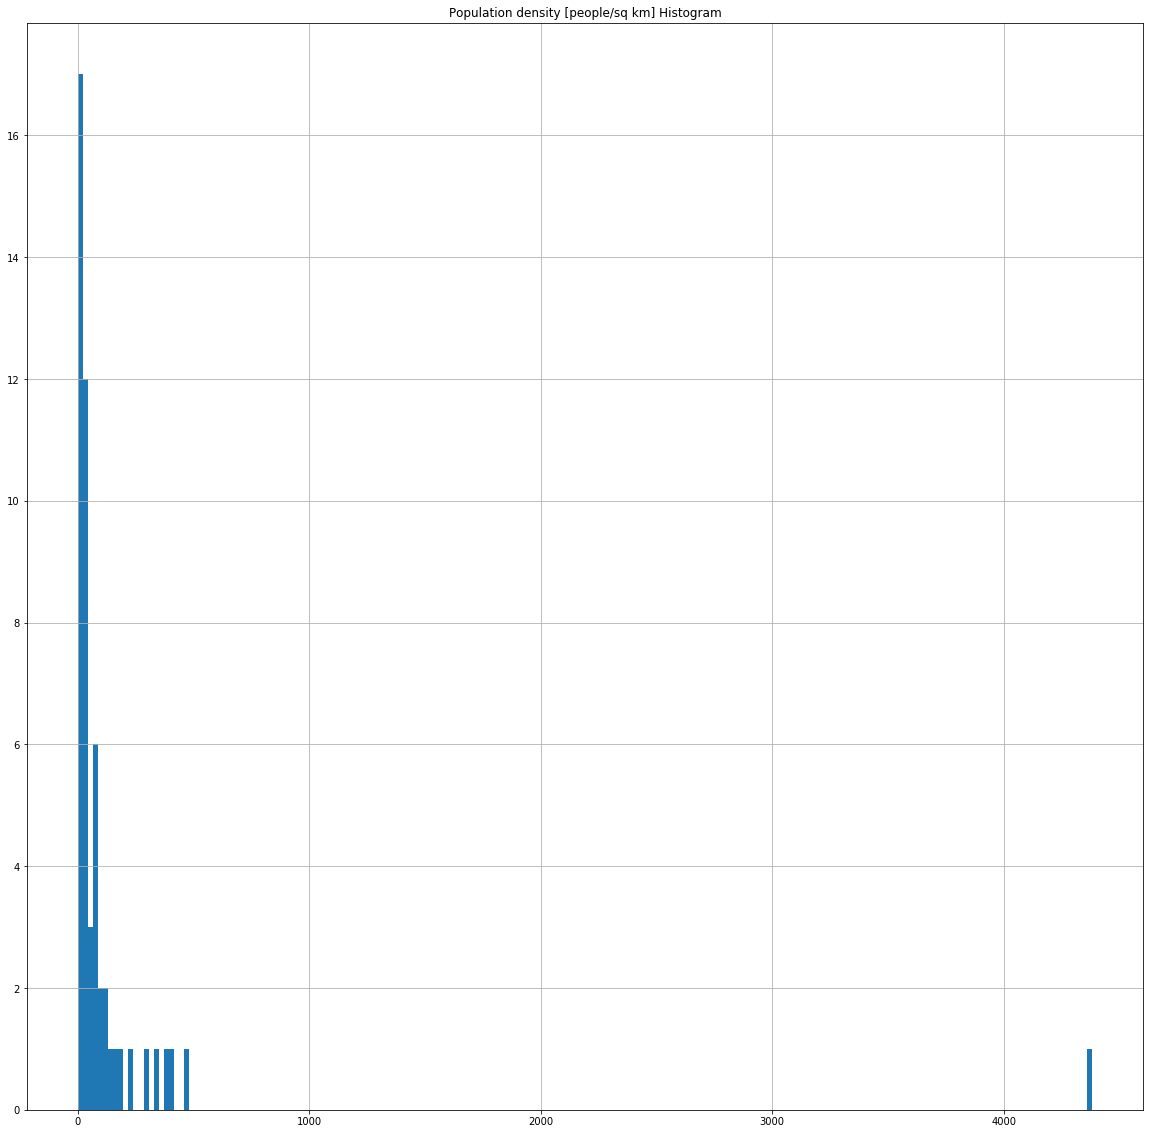

In [134]:
figsize = (20, 20)
fig, ax = plt.subplots(1, 1, figsize=figsize)
ax.set_title('Population density [people/sq km] Histogram')
hist = df_map['population_density'].hist(bins=200, figsize=figsize)

In [135]:
#find state with lowest population density
df_map.loc[df_map['population_density'].idxmin()]

statefp                                                              02
statens                                                        01785533
affgeoid                                                    0400000US02
geoid                                                                02
stusps                                                               AK
name                                                             Alaska
lsad                                                                 00
aland                                                     1478588231566
awater                                                     277723861311
geometry              (POLYGON ((-173.074642 60.704657, -172.912636 ...
pop_2017_est                                                     739795
population_density                                             0.500339
Name: 1, dtype: object

# sort by population density

In [136]:
# select 2 columns, sort.
# doesn't mutate dataframe if don't set inplace True and don't reassign to df_map
df_map[['name','population_density']].sort_values(by= ['population_density'], ascending=False).head()

,name,population_density
8,District of Columbia,4382.474374
30,New Jersey,472.744084
40,Rhode Island,395.683336
39,Puerto Rico,376.285576
21,Massachusetts,339.522935


# Add column awater_frac

In [137]:
df_map['awater_frac'] = df_map['awater'] / (df_map['aland'] + df_map['awater'])
df_map.iloc[:, 5:].sort_values(by= ['awater_frac'], ascending=False).head()

,name,lsad,aland,awater,geometry,pop_2017_est,population_density,awater_frac
22,Michigan,00,146488062160,103998746281,"(POLYGON ((-84.61622 45.89447, -84.517895 45.8...",9962311.0,68.007665,0.415187
11,Hawaii,00,16634117742,11777681513,"(POLYGON ((-156.049651 19.780452, -156.006267 ...",1427538.0,85.819881,0.414535
39,Puerto Rico,00,8868734851,4922543816,"(POLYGON ((-65.342068 18.34529, -65.255933 18....",3337177.0,376.285576,0.356932
40,Rhode Island,00,2677997539,1323452846,"(POLYGON ((-71.631472 41.166678, -71.593341999...",1059639.0,395.683336,0.330743
21,Massachusetts,00,20204287539,7130763257,"(POLYGON ((-70.275526 41.310464, -70.193711999...",6859819.0,339.522935,0.260865


# Draw chloropleth map of population density
http://geopandas.org/mapping.html

In [ ]:
# cx coordinate based indexing
df_map = df_map.cx[-179:-65, 0:80]

cmap = 'viridis'
num_colors = 40
vmin=0
vmax=100

# https://stackoverflow.com/questions/39215202/matplotlib-geopandas-plot-multiple-layers-control-figsize
figsize = (20, 20)
fig, ax = plt.subplots(1, 1, figsize=figsize)
ax.set_title('Population density [people/sq km]')

df_map.plot(column='population_density', cmap=cmap, ax=ax, k=num_colors, legend=False, vmin=vmin, vmax=vmax)

# Increase plot vertical size - workaround, omit Alaska and Hawaii

In [ ]:
# cx coordinate based indexing
# http://geopandas.org/indexing.html
df_non_alaska = df_map.cx[-120:-65, 0:80]

num_colors = 40
vmin=0
vmax=300

# https://stackoverflow.com/questions/39215202/matplotlib-geopandas-plot-multiple-layers-control-figsize
figsize = (20, 20)
fig, ax = plt.subplots(1, 1, figsize=figsize)
ax.set_title('Population density [people/sq km]')
df_non_alaska.plot(column='population_density', cmap=cmap, ax=ax, k=num_colors, legend=True, vmin=vmin, vmax=vmax)

# Draw chloropleth map of awater_frac

In [ ]:
cmap = 'Blues'
num_colors = 40
vmin=0
vmax=0.2

# https://stackoverflow.com/questions/39215202/matplotlib-geopandas-plot-multiple-layers-control-figsize
figsize = (20, 20)
fig, ax = plt.subplots(1, 1, figsize=figsize)
ax.set_title('Fractional water area')

df_non_alaska.plot(column='awater_frac', cmap=cmap, ax=ax, k=num_colors, legend=True, vmin=vmin, vmax=vmax)

# scatter plot population density vs fractional water area

In [ ]:
# prepare for scatterplot
# geopandasdataframe didn't work with scatter plot, so create a new dataframe
df_water_pop = pd.concat([df_map['name'], df_map['awater_frac'], df_map['population_density']], axis=1)
df_water_pop.head()

In [ ]:
df_water_pop.plot.scatter(x='awater_frac', y='population_density', figsize=figsize)